# References

## Transformer

* [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf)
* [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf)
* [FlashAttention](https://arxiv.org/pdf/2205.14135.pdf)

## Nano GPT

Nano GPT implementation by Andrej Karpathy.

### Nano GPT YouTube Lecture version

This is for lecture only. The Github is different from the proper implementation of Nano GPT github. Do not confuse/mix two diffent Github repositories.

* [Let's build GPT: from scratch, in code, spelled out.](https://www.youtube.com/watch?v=kCc8FmEb1nY)
* [Github - nanogpt-lecture](https://github.com/karpathy/ng-video-lecture)

> Code created in the Neural Networks: Zero To Hero video lecture series, specifically on the first lecture on nanoGPT. Publishing here as a Github repo so people can easily hack it, walk through the git log history of it, etc.


### Nano GPT implementation version
* [Github nanoGPT](https://github.com/karpathy/nanoGPT)

## Resources

* [Understanding Large Language Models](https://magazine.sebastianraschka.com/p/understanding-large-language-models)
* [Building a Transformer with PyTorch](https://www.datacamp.com/tutorial/building-a-transformer-with-py-torch)

# Setup

In [1]:
%%html
<style>
table {float:left}
</style>

In [2]:
import os
import sys

DIR = os.path.dirname(os.path.abspath('..'))
if DIR not in sys.path:
    sys.path.append(DIR)

In [3]:
%load_ext autoreload
%autoreload 2

import math
import inspect
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from transformer.v1 import (
    TYPE_FLOAT,
    DROPOUT_RATIO,
    initialize_weights,
    split,
    calculate_dot_product_similarities,
    scale,
    mask,
    softmax,
    calculate_attention_values,
    MultiHeadAttention,
    ScaledDotProductAttention,
    PositionwiseFeedForward,
    PositionalEncoding,
    EncodeLayer,
    Encoder,
)

In [4]:
# torch.set_printoptions(profile="full")
torch.set_printoptions(edgeitems=4)
torch.set_printoptions(threshold=100)
torch.set_printoptions(linewidth=200)

---

# Data

Using tinyshakespeare as the dataset

In [5]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

# Terminologies

* B: Batch size
* T: Time steps or Sequence length (e.g. 512 for bert input sequence)
* C: Channel or Feature (channel perhaps because Andrej is from CNN background?). ```C=2``` two features in each x.

## Batch Input

<img src="./image/gpt_batch.jpeg" align="left" width=750/>


## Bigram Language Model

The Bigram Language Model is **NOT using context of size T** but using the current token to predict next token, hence **Bi**gram. The objective of a Language Model is to use the historycal context, but here in the Bigram Model, Andrej is building very simple Markov Chain process to **generate next token only from the current token** for the sake of explaning the basic idea of token generation with bare naked possible way as he mentioned at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2077) and [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2261).

> right now the history is not used, so it looks silly (but eventually history will be used). ...
> 
> Given the previous context of whatever generated, we only look at the very last character (```[:, -1, :]```) to make the prediciton of what comes next.

* [Let's build GPT: from scratch, in code, spelled out - simplest baseline](https://youtu.be/kCc8FmEb1nY?t=1383)

The ```idx:shape(B,T)``` is the idices to extract ```T``` number embedding vectors for the tokens. The ```token_embedding_table``` is e.g. a table of word embeddings in Word2Vec for each word in the vocabulary of the language. Andrej is using ```vocab_size``` as the dimension of the token embedding vector dimensions, hence the table has ```(number of words in language, dimensions)==(vocab_size, vocab_size)```. 

The reason using ```vocab_size``` as the dimensions is because Andrej simlifies the classification head which predicts the next token. Usually there is a **fully connected (FC)** layer that reduces the higher dimension down to N classes to predict, then apply softmax and argmax to select the hightest probability token index. Here, he skipped **FC** and directly generate N class outputs where ```N==vocab size``` so that the model can directly predict which word in the vocabulary to come next as GPT output.

<img src="./image/andrej_gpt_dev_idx.png" align="left" width=500/>

The ```generate``` function is the mechanism to continuously generate the next tokens from the given context (prompt). In this Bigram Language Model, the (last) token predicts the next token, hence take the last token embedding vector with ```[:, -1, :]``` to get the next token id via softmax and argmax (```torch.multinomial(, num_samples=1)```) as the next token.

<img src="./image/text_generation_from_prompt.png" align="left" width=500/>

This corresponds with GPT generates succeeding sentences given a prompt (context). 

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=1934)

By giving an index to one token as the first ```idx``` to the ```generate``` function, it will continuously generates ```max_new_tokens```.

```
# 0 as the index to the first token in the embedding table
first_token_index: int = torch.zeros((1, 1)  

# [0] to get first batch
first_batch = decode(m.generate(idx=first_token_index, dtype=torch.long), max_new_tokens=100)[0].tolist())  
print(first_batch)
```

<img src="./image/next_token_generation.jpeg" align="left" width=750/>

In [6]:
# print(inspect.getsource(get_batch))

---
# Basics

## Attention 

$$Attention(Q,K,V)=softmax(\frac {QK^T}{\sqrt {d_k}})$$


* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4301)
* [Building a GPT](https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-)

> - Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
> - There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
> - Each example across batch dimension is of course processed completely independently and never "talk" to each other
> - In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
> - "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
> - "Scaled" attention additional divides `similarity` by ```1/sqrt(head_size)```. This makes it so when input Q,K are unit variance, `similarity` will be unit variance too and Softmax will stay diffuse and not saturate too much.
> 
> <img src="./image/transformer_attention_as_communication.png" align="left" width=250/>

## Dot Product

Transformer uses Scaled Dot Product Attention. Refresh the memory on what dot-product transformation does and where they are used.

* Similarity = Q@K
* Attention Valuye = Similarity@V

<img src="./image/transformer_self_attention_flow.jpeg" align="left"/>

## Layer Normazliation and Residual Dropout

Original paper applied Dropout to the Sub-Layer (Multi Head Attention) before Residual Connection and Layer Normalization. This is called **Post Normalization**. 

> dropout to the output of each sub-layer, **before** it is added to the sub-layer input (x) and (layer) normalized.


<img src="./image/transformer_residual_dropout.png" align="left" width=800/>


However, recent approach is **Pre Normalization** where LayerNorm is applied to the input x into the sub-layer as explained in [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=5729)

> Very few details about the Transformer have changed in the last five years, but there is something slightly departs from the original paper. You see that Add and Norm is applied **after** the transformation (Multi Head Attention). But now it is more common to apply LayerNorm before the transformation, so there is a reshuffling of the Layer Norm. This is called **pre-norm formulation** and that is the one we are going to implement as well.

It is proposed in [On Layer Normalization in the Transformer Architecture](https://arxiv.org/pdf/2002.04745.pdf).

> On the other hand, our theory also shows that if the layer normalization is put inside the residual blocks (recently proposed as Pre-LN Transformer), the gradients are well-behaved at initialization. This motivates us to remove the warm-up stage for the training of Pre-LN Transformers. We show in our experiments that Pre-LN Transformers without the warm-up stage can reach comparable results with baselines while requiring significantly less training time and hyper-parameter tuning on a wide range of applications.
> 
> <img src="./image/pre-ln-transformer.png" align="left" width=600/>

* [Review — Pre-LN Transformer: On Layer Normalization in the Transformer Architecture
Pre-LN Transformer, Warm-Up Stage is Skipped](https://sh-tsang.medium.com/review-pre-ln-transformer-on-layer-normalization-in-the-transformer-architecture-b6c91a89e9ab)
* [About LayerNorm Variants in the Original Transformer Paper, and Some Other Interesting Historical Tidbits About LLMs](https://magazine.sebastianraschka.com/p/why-the-original-transformer-figure)

<img src="./image/post_ln_to_pre_ln_transformer.jpeg" align="left"/>

---
# Transformer (Pre-LN)

(The Transformer implementaion starting at [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=2268))

Transformer generates a graph network between position-encoded tokens.

1. Get un-connected tokens as a sequence (e.g. sentence)
2. Wires connections among tokens by having looked at the co-occurrances of them in billions of sequences.


<img src="./image/transformer_pre_ln.png" align="left" width=700/>

In [7]:
_B = 1    # Batch size
_H = 2    # Number of heads
_T = 4    # Time steps / Sequence length
_D = 8    # Model vector dimension d_model
d_ff = _D * 4    # Pointwise Feed Forward hidden layer dimenssion


# Token Embedding
embedding = torch.nn.Embedding(
    num_embeddings=_T,
    embedding_dim=_D
)
initialize_weights(module=embedding)
DOe = torch.nn.Dropout(p=DROPOUT_RATIO)

# Linear projections at Attention
Wq = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
Wk = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
Wv = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
Wo = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
initialize_weights(Wq)
initialize_weights(Wk)
initialize_weights(Wv)
initialize_weights(Wo, output_projection=True)

# LayerNorm and Dropout for attention
LNa = torch.nn.LayerNorm(normalized_shape=_D, eps=1e-5, bias=True, dtype=TYPE_FLOAT)
DOa = torch.nn.Dropout(p=DROPOUT_RATIO)

# Linear projections at Position Wise Feed Forward
W1 = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
W2 = torch.nn.Linear(_D, _D, bias=True, dtype=TYPE_FLOAT)
initialize_weights(module=W1)
initialize_weights(module=W2, output_projection=True)
relu = torch.nn.ReLU()

# LayerNorm and Dropout for position-wise feed-forward
LNp = torch.nn.LayerNorm(normalized_shape=_D, eps=1e-5, bias=True, dtype=TYPE_FLOAT)
DOp = torch.nn.Dropout(p=DROPOUT_RATIO)

# Input Embedding

<img src="./image/transformer_embedding.png" align="left" width=750/>

In [8]:
indices = torch.arange(0, _B * _T).view(_B, _T)    # Token IDs / Indices to token embedding vectors
x = embedding(indices) * math.sqrt(_D)
x.shape == (_B, _T, _D)
x

tensor([[[-0.0783, -0.0493, -0.0126,  0.0971,  0.0180, -0.0240,  0.0173, -0.0438],
         [-0.0881,  0.0563, -0.0498, -0.0340, -0.0721,  0.1201, -0.0698, -0.0276],
         [-0.0517, -0.0372,  0.0044,  0.0297, -0.0276,  0.0674, -0.0460, -0.0416],
         [-0.0794,  0.0020, -0.0036,  0.0382, -0.0055,  0.1043, -0.0670,  0.0783]]], grad_fn=<MulBackward0>)

# Positional Encoding and Dropout

Position encoding vector is added to the token embedding vector. Dropout is applied to the position added embedding.

<img src="./image/transformer_dropout_to_embedding.png" align="left" width=750/>

In [9]:
pe = PositionalEncoding(max_time_steps=_T, d_model=_D)
positions = pe(x)
positions

tensor([[[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  1.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  9.9833e-02,  9.9500e-01,  9.9998e-03,  9.9995e-01,  1.0000e-03,  1.0000e+00],
         [ 9.0930e-01, -4.1615e-01,  1.9867e-01,  9.8007e-01,  1.9999e-02,  9.9980e-01,  2.0000e-03,  1.0000e+00],
         [ 1.4112e-01, -9.8999e-01,  2.9552e-01,  9.5534e-01,  2.9995e-02,  9.9955e-01,  3.0000e-03,  1.0000e+00]]])

In [10]:
x = DOe(x + positions)
x

tensor([[[-0.0870,  1.0564, -0.0140,  1.2191,  0.0200,  0.0000,  0.0192,  0.0000],
         [ 0.8371,  0.6629,  0.0556,  1.0678, -0.0690,  1.2445, -0.0765,  1.0804],
         [ 0.9529, -0.5038,  0.2256,  1.1220, -0.0085,  1.1858, -0.0489,  1.0648],
         [ 0.0686, -1.0977,  0.3244,  1.1040,  0.0000,  1.2266, -0.0711,  1.1981]]], grad_fn=<MulBackward0>)

# Pre Layer Normalization

Laye Normalization is applied to the input to the sub-layer.

In [11]:
x = LNa(x)
x

tensor([[[-0.7278,  1.5600, -0.5818,  1.8856, -0.5136, -0.5537, -0.5152, -0.5537],
         [ 0.4591,  0.1213, -1.0565,  0.9066, -1.2982,  1.2493, -1.3127,  0.9311],
         [ 0.7387, -1.6306, -0.4442,  1.0137, -0.8250,  1.1174, -0.8908,  0.9207],
         [-0.3660, -1.9157, -0.0262,  1.0096, -0.4572,  1.1725, -0.5517,  1.1347]]], grad_fn=<NativeLayerNormBackward0>)

# Split for Multi Heads

In [12]:
q = split(Wq(x), h=_H)
k = split(Wk(x), h=_H)
v = split(Wv(x), h=_H)

print(k.shape)    # (B,H,T,d_k)
k

torch.Size([1, 2, 4, 4])


tensor([[[[ 0.0076, -0.0204,  0.0750, -0.1073],
          [-0.0076, -0.0264,  0.0124, -0.0203],
          [ 0.0347,  0.0079, -0.0192,  0.0299],
          [ 0.0113,  0.0318, -0.0036,  0.0251]],

         [[ 0.0610, -0.0066, -0.0240, -0.0667],
          [ 0.0291,  0.0549,  0.0408, -0.1296],
          [-0.0150,  0.0546,  0.0594, -0.1035],
          [-0.0006,  0.0117,  0.0272, -0.0461]]]], grad_fn=<TransposeBackward0>)

# Scaled Dot Product Attention

<img src="./image/transformer_attention.png" align="left"/>

In [13]:
print(inspect.getsource(ScaledDotProductAttention))

class ScaledDotProductAttention(nn.Module):
    """
    Class to implement Scaled Dot Product Attention (Figure 2 left in the paper).
    """
    def __init__(self, do_mask: bool, max_time_steps: Optional[int]):
        """
        Args:
            max_time_steps: max sequence length or time steps T
        """
        mask_matrix: Optional[Tensor]
        super().__init__()
        if do_mask:
            mask_matrix = torch.tril(torch.ones(max_time_steps, max_time_steps)) == 0
        else:
            mask_matrix = None

        self.register_buffer("mask_matrix", mask_matrix)
        assert (
            (not do_mask and self.mask_matrix is None) or
            (do_mask and self.mask_matrix.ndim == 2 and self.mask_matrix.shape[-1] == max_time_steps)
        )

    def forward(
            self,
            q: Tensor,
            k: Tensor,
            v: Tensor,
    ):
        """Calculate the scaled dot product attention.
        Args:
            q: query of shape (B,h,T,d)
    

## First MatMul with Q and K (Calculate Similarity Score)

For every token ```Q``` in a sequence, calculate the relation/communication with other token ```K``` in the sequence (for GPT, only previous tokens). This builds the graph network of Self Attention.


|Similarity Score (Q & K)| Proabability as Softmax |
|---|---|
|<img src="./image/transformer_dot_product_attention_similarity_score.jpeg" align="left" width=500/>|<img src="./image/transformer_dot_product_attention.png" align="left" width=175/>|


In [14]:
print(inspect.getsource(calculate_dot_product_similarities))

def calculate_dot_product_similarities(
        query: Tensor,
        key: Tensor,
) -> Tensor:
    """
    Calculate similarity scores between queries and keys using dot product.

    Args:
        query: embedding vector of query of shape (B, h, T, d_k)
        key: embedding vector of key of shape (B, h, T, d_k)

    Returns: Similarities (closeness) between q and k of shape (B, h, T, T) where
        last (T, T) represents relations between all query elements in T sequence
        against all key elements in T sequence. If T is people in an organization,
        (T,T) represents all (cartesian product) social connections among them.
        The relation considers d_k number of features.
    """
    # --------------------------------------------------------------------------------
    # Relationship between k and q as the first MatMul using dot product similarity:
    # (B, h, T, d_k) @ (B, hH, d_k, T) ---> (B, h, T, T)
    # --------------------------------------------------------

In [15]:
similarities = calculate_dot_product_similarities(query=q, key=q)
print(similarities.shape)    # (B,H,T,T)
print(similarities)

torch.Size([1, 2, 4, 4])
tensor([[[[ 0.0026,  0.0028,  0.0024,  0.0011],
          [ 0.0028,  0.0140,  0.0089,  0.0031],
          [ 0.0024,  0.0089,  0.0096,  0.0079],
          [ 0.0011,  0.0031,  0.0079,  0.0108]],

         [[ 0.0048,  0.0003, -0.0069, -0.0085],
          [ 0.0003,  0.0024,  0.0032,  0.0037],
          [-0.0069,  0.0032,  0.0179,  0.0214],
          [-0.0085,  0.0037,  0.0214,  0.0265]]]], grad_fn=<UnsafeViewBackward0>)



## Scale by $\sqrt{d_k}$

### Control the variance

As in the name **Scaled** Dot-Product Attention, the similarity score is normalized by $\sqrt{d_k}$ to manage the variance where $d_k$ is the dimension of the key vector $k$ (which is the same with that of query).

Providing $W$ is initialized with Xavier so that the variance of $X@W^T$ will be 1.0. Suppose the positionally encoded token vector $x$ has dimension $D$, the shape of $W_K$ is ```(M, D)```. Then key $k = x:(D,) @ W^T_K:(D,M)$ has the shape $(M,)$, which is $d_k$. The variance of the pdorduct $Q\cdot K^T$ is $d_k$. The variance of two zero-mean normal distributions is:

[Variance of product of multiple independent random variables](https://stats.stackexchange.com/questions/52646/)

$${\rm Var}(XY) = E(X^2Y^2) − (E(XY))^2={\rm Var}(X){\rm Var}(Y)+{\rm Var}(X)(E(Y))^2+{\rm Var}(Y)(E(X))^2$$  $$E(X)=E(Y)=0$$

<img src="./image/variance_of_q@k.jpeg" align="left" width=500/>

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4616)

> If you have unit gausian input of mean 0 and $W_K$ and $W_V$ are unit gaussian, and if you calculate the ```similarity``` naively, the variance is the order of the head size $d_k$ (e.g. approx 16 if $d_k$ == 16). By standardizing the ```similarity``` score by $\sqrt{d_k}$ the variance of the ```similarity``` socre will be normal (approx 1.0).



### Soften the softmax outputs

#### Effect of exponential

Exponential has amplify/supress effects when the signal has large variance with their values being negative and positive. Hence, only the large positive signal value gets amplified and others towards negatives get supressed.

This is desirable to predict one class so that only one class stands out. But to incorporate all the signals, this amplify/supression is undesirable. By standardizing the signals (scale with the std of the signals), the exponentials get softened.

Text(0.5, 1.0, 'standardized variance 1 with negative/positive range')

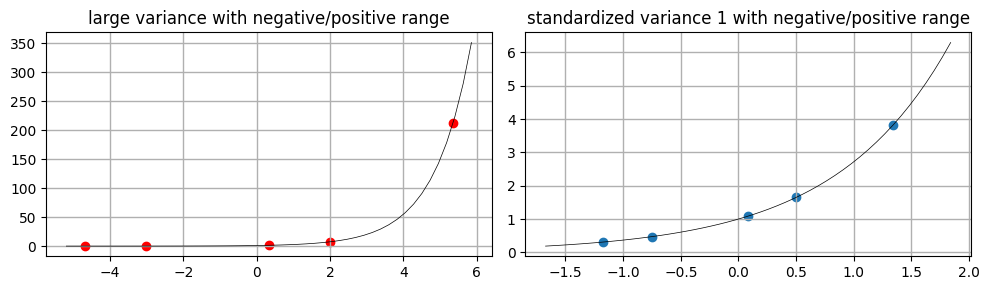

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3),  tight_layout=True) 
plt.grid()

head_size = 16
normalized_qk = torch.tensor(sorted([ 0.0838, -0.7539,  0.5026, -1.1728,  1.3405]))
naive_qk = normalized_qk * torch.sqrt(torch.tensor(head_size))

# Variance=head_size=d_k

_x = np.linspace(naive_qk[0]-0.5, naive_qk[-1]+0.5)
axes[0].plot(_x, np.exp(_x), color='k', linewidth=0.5)
axes[0].scatter(naive_qk, torch.exp(naive_qk), color='r')
axes[0].set_title("large variance with negative/positive range")
axes[0].grid(linestyle='-', linewidth=1)

# Variance = 1

_x = np.linspace(normalized_qk[0]-0.5, normalized_qk[-1]+0.5)
axes[1].plot(_x, np.exp(_x), color='k', linewidth=0.5)
axes[1].scatter(normalized_qk, torch.exp(normalized_qk))
axes[1].grid(linestyle='-', linewidth=1)
axes[1].set_title("standardized variance 1 with negative/positive range")


#### Without scaling

When the similarity score is not normalized/scaled by $\sqrt{d_k}$, the softmax becomes **peaky** like one hot encoding, which is beneficial for classification (amplify the high score signal). However, for self attention, softmax will pickup the nodes with larger values, hence only specific nodes in the sequence will be incorporated into the BoW. We want to consider the communication among every nodes if there is, not specific ones only.

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=4694)

> The problem here, because of the softmax, if the $Q@K$ takes very positive or very negative numbers inside it, softmax will converge towards one hot vectors.

VAR[qk]=1.0000985860824585
variance:16.001577377319336, softmax:tensor([6.2962e-03, 2.2072e-04, 3.3621e-02, 4.1318e-05, 9.5982e-01])


<StemContainer object of 3 artists>

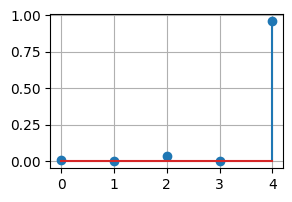

In [17]:
head_size = 16
normalized_qk = torch.tensor([ 0.0838, -0.7539,  0.5026, -1.1728,  1.3405])
print(f"VAR[qk]={torch.var(normalized_qk)}")

# Note that variance of Q@K is close to the head_size d_k
# # scale with std to make the variance==head_size
naive_qk = normalized_qk * torch.sqrt(torch.tensor(head_size))
print(f"variance:{naive_qk.var()}, softmax:{torch.softmax(naive_qk, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(naive_qk)), torch.softmax(naive_qk, dim=-1))

#### With scaling

By scale/normalize, the softmax will be smoothed/diffused.

variance:1.0000985860824585, softmax:tensor([6.2962e-03, 2.2072e-04, 3.3621e-02, 4.1318e-05, 9.5982e-01])


<StemContainer object of 3 artists>

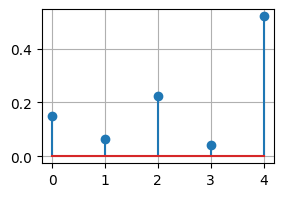

In [18]:
scaled_qk = naive_qk / torch.sqrt(torch.tensor(head_size))
print(f"variance:{scaled_qk.var()}, softmax:{torch.softmax(naive_qk, dim=-1)}")

plt.figure(figsize=(3,2))
plt.grid()
plt.stem(range(len(scaled_qk)), torch.softmax(scaled_qk, dim=-1))

### Code for Scale

In [19]:
print(inspect.getsource(scale))

def scale(
        similarities: Tensor,
        d_k: int
) -> Tensor:
    """
    Standardize the variance of the dot product similarities using the standard deviation
    of the dot product of the normal distributions std=sqrt(d_k) so that the variance will
    be 1.0 approx.

    Citation:
    > While for small values of dk the two mechanisms perform similarly, additive attention
    > outperforms dot product attention without scaling for larger values of dk [3].
    > We suspect that for large values of d_k, the dot products grow large in magnitude,
    > pushing the softmax function into regions where it has extremely small gradients.
    > To counteract this effect, we scale the dot products by sqrt(d_k).

    The last (T, T) of the shape (B,h,T,T) is the matrix that represents the similarities
    as the dot product between (q,k) from every q from sequence length T and k from the
    sequence length T. The dimensions of q and k are both d_k, and q, k are expected to
    follow n

In [20]:
scaled_similarities = scale(similarities=similarities, d_k=_D/_H)
scaled_similarities

tensor([[[[ 0.0013,  0.0014,  0.0012,  0.0005],
          [ 0.0014,  0.0070,  0.0044,  0.0015],
          [ 0.0012,  0.0044,  0.0048,  0.0039],
          [ 0.0005,  0.0015,  0.0039,  0.0054]],

         [[ 0.0024,  0.0002, -0.0035, -0.0042],
          [ 0.0002,  0.0012,  0.0016,  0.0019],
          [-0.0035,  0.0016,  0.0089,  0.0107],
          [-0.0042,  0.0019,  0.0107,  0.0133]]]], grad_fn=<DivBackward0>)

## Mask

Optional. After calculating ```(T,T)``` matrix of similarities from q to k, mask the matrix to prevent the communications with future time steps by replacing the similarity values with the ```-inf```, meaning there is **no relationship** from ```q```. Then softmax will make the contribution from the ```-inf``` to zero. This is the same with blocking relations between ```q``` and ```k```.


### Demonstration

In [21]:
# Mask matrix to decide which element in (T,T) matrix to mask
mask_matrix = torch.tril(torch.ones(_T,_T)) == 0
mask_matrix

tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])

In [22]:
# Mask the similarity matrix element of future steps with -inf

masked_similarities = torch.clone(similarities).masked_fill(mask=mask_matrix, value=float('-inf'))
masked_similarities

tensor([[[[ 0.0026,    -inf,    -inf,    -inf],
          [ 0.0028,  0.0140,    -inf,    -inf],
          [ 0.0024,  0.0089,  0.0096,    -inf],
          [ 0.0011,  0.0031,  0.0079,  0.0108]],

         [[ 0.0048,    -inf,    -inf,    -inf],
          [ 0.0003,  0.0024,    -inf,    -inf],
          [-0.0069,  0.0032,  0.0179,    -inf],
          [-0.0085,  0.0037,  0.0214,  0.0265]]]], grad_fn=<MaskedFillBackward0>)

In [23]:
# Softmax will supress the contirubion from -inf similarity values
F.softmax(masked_similarities, dim=-1)

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4972, 0.5028, 0.0000, 0.0000],
          [0.3318, 0.3340, 0.3342, 0.0000],
          [0.2488, 0.2493, 0.2505, 0.2513]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4995, 0.5005, 0.0000, 0.0000],
          [0.3295, 0.3328, 0.3377, 0.0000],
          [0.2452, 0.2482, 0.2526, 0.2539]]]], grad_fn=<SoftmaxBackward0>)

### Code for Mask

In [24]:
print(inspect.getsource(mask))

def mask(
    similarities: Tensor,
    mask_matrix: Tensor
) -> Tensor:
    """
    Args:
        similarities: matrix to mask of shape (B,H,T,T)
        mask_matrix: boolean matrix of which elements in (T,T) to mask fill.

    Returns: masked similarity matrix
    """
    # --------------------------------------------------------------------------------
    # mask to make uni-direction (left to right only) for algorithm such as GPT.
    # Skip masking for bi-directional e.g .BERT,
    # --------------------------------------------------------------------------------
    # exp(-inf) = 0 masks the similarities so that it will be uni-directional.
    assert (
        similarities.ndim == 4 and                              # (B,H,T,T)
        similarities.shape[-2] == similarities.shape[-1] and
        similarities.shape[-1] == mask_matrix.shape[-1]
    )
    masked = similarities.masked_fill(mask=mask_matrix, value=float('-inf'))
    return masked



In [25]:
masked_similarities = mask(similarities=similarities, mask_matrix=mask_matrix)
masked_similarities

tensor([[[[ 0.0026,    -inf,    -inf,    -inf],
          [ 0.0028,  0.0140,    -inf,    -inf],
          [ 0.0024,  0.0089,  0.0096,    -inf],
          [ 0.0011,  0.0031,  0.0079,  0.0108]],

         [[ 0.0048,    -inf,    -inf,    -inf],
          [ 0.0003,  0.0024,    -inf,    -inf],
          [-0.0069,  0.0032,  0.0179,    -inf],
          [-0.0085,  0.0037,  0.0214,  0.0265]]]], grad_fn=<MaskedFillBackward0>)

In [26]:
normalized_similarities = softmax(masked_similarities, dim=-1)
normalized_similarities

tensor([[[[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4972, 0.5028, 0.0000, 0.0000],
          [0.3318, 0.3340, 0.3342, 0.0000],
          [0.2488, 0.2493, 0.2505, 0.2513]],

         [[1.0000, 0.0000, 0.0000, 0.0000],
          [0.4995, 0.5005, 0.0000, 0.0000],
          [0.3295, 0.3328, 0.3377, 0.0000],
          [0.2452, 0.2482, 0.2526, 0.2539]]]], grad_fn=<SoftmaxBackward0>)

## Second MatMul with V (Calculate Bag of Words Attention Value)

One way to generate the inter-connections among the tokens to distill their knowledges or relations is ```BoW``` by averaging them feature-wise/axis=-1.



<img src="./image/transformer_dot_product_attention_bow.png" align="left" width=700/>  

Note that the initially the value of similarity is random or ```(1.0, 1/2, 1/3, ...)``` but eventually it gets trained to memorize the relations among position-encoded tokens.

* [Let's build GPT: from scratch, in code, spelled out.](https://youtu.be/kCc8FmEb1nY?t=3814)

> Different will find other tokens more or less interesting and we want that data dependent. If I/token is a vowel, I am looking for consonants in my past and want to know what consonants were. And I want the information to flow to me (connection). This is the problem that Self Attention solves.

<img src="./image/self_attention.jpeg" align="left" width=700/>

### Purpose of  using $W_V$

$v$ looks to be a proxy of $x$ but what transformation or meaning does $W_V$ gives by having transformation from $x$ to $v$? (Note: ```x``` in the diagram above is actually $v$ as $v=x@W{_V}{^T}$).

* [Let's build GPT: from scratch, in code, spelled out](https://youtu.be/kCc8FmEb1nY?t=4258)

> $x$ is like a private information to a token. For the purpose of the single attention head, $v$ is what I give for you to communicate with if you find me interesting.

### Code

In [27]:
print(inspect.getsource(calculate_attention_values))

def calculate_attention_values(
        similarities,
        values
):
    """
    For every q element, create a Bag of Words that encodes the relationships with
    other elements (including itself) in T, using (q,k) relationship value as the
    strength of the relationships.

    Citation:
    > On each of these projected versions of queries, keys and values we then perform
    > the attention function in parallel, yielding d_v-dimensional output values.

    ```
    bows = []
    for row in similarities:                    # similarity matrix of shape (T,T)
        bow = sum([                             # bow:shape(d_v,)
            # each column in row is (q,k) similarity score s
            s*v for (s,v) in zip(row,values)    # k:shape(), v:shape(d_v,)
=        ])
        bows.append(bow)                        # bows:shape(T,d_v)
    ```

    Args:
        similarities: q to k relationship strength matrix of shape (B, h, T, T)
        values: elements of sequence with length T

In [28]:
attensions = calculate_attention_values(similarities=normalized_similarities, values=v)
print(attensions.shape)    # (B,H,T,d_v)
attensions

torch.Size([1, 2, 4, 4])


tensor([[[[ 0.0252, -0.0309, -0.0251, -0.0567],
          [ 0.0306, -0.0221,  0.0235, -0.0293],
          [ 0.0178, -0.0226,  0.0428,  0.0120],
          [-0.0047, -0.0216,  0.0461,  0.0445]],

         [[ 0.0393,  0.0054,  0.0070, -0.0624],
          [ 0.0052,  0.0427, -0.0217, -0.0740],
          [-0.0110,  0.0511, -0.0106, -0.0645],
          [-0.0124,  0.0461, -0.0127, -0.0548]]]], grad_fn=<UnsafeViewBackward0>)

### Verify ScaledDotProductAttention

In [29]:
sdpa = ScaledDotProductAttention(do_mask=True, max_time_steps=_T)
sdpa(q=q,k=k,v=v)

tensor([[[[ 0.0252, -0.0309, -0.0251, -0.0567],
          [ 0.0306, -0.0222,  0.0233, -0.0294],
          [ 0.0178, -0.0226,  0.0427,  0.0120],
          [-0.0046, -0.0216,  0.0460,  0.0443]],

         [[ 0.0393,  0.0054,  0.0070, -0.0624],
          [ 0.0053,  0.0427, -0.0217, -0.0740],
          [-0.0107,  0.0509, -0.0107, -0.0646],
          [-0.0121,  0.0460, -0.0128, -0.0550]]]], grad_fn=<UnsafeViewBackward0>)

# Multi Attention Head

Divide the embedding vector q, k, v into ```h``` number of segmenets and apply self attention to each segment in parallel respectively.

* <img src="./image/transformer_paper_multi_head_attention.png" align="left" width=700/>


|<img src="./image/transformer_multi_head_attentions.png" align="left" width=200/>   | 
<img src="./image/transformer_multi_head_attention_formula.png" align="left" width=700/> |

* [Transformers Explained Visually (Part 3): Multi-head Attention, deep dive](https://towardsdatascience.com/transformers-explained-visually-part-3-multi-head-attention-deep-dive-1c1ff1024853)

<img src="./image/transformer_multi_head_attention.png" align="left" width=500/>

### Concatenate multiple outputs from Heads

In [30]:
attensions = attensions.transpose(2,1)  # (B,T,H,d_v)
attentions = attensions.reshape(_B,_T,-1)
print(attentions.shape)    # (B,T,D)
attentions

torch.Size([1, 4, 8])


tensor([[[ 0.0252, -0.0309, -0.0251, -0.0567,  0.0393,  0.0054,  0.0070, -0.0624],
         [ 0.0306, -0.0221,  0.0235, -0.0293,  0.0052,  0.0427, -0.0217, -0.0740],
         [ 0.0178, -0.0226,  0.0428,  0.0120, -0.0110,  0.0511, -0.0106, -0.0645],
         [-0.0047, -0.0216,  0.0461,  0.0445, -0.0124,  0.0461, -0.0127, -0.0548]]], grad_fn=<UnsafeViewBackward0>)

### Linear Projection

In [31]:
attentions = Wo(attentions)
print(attentions.shape)    # (B,T,D)
attentions

torch.Size([1, 4, 8])


tensor([[[-1.0053e-03, -6.3895e-04, -1.4211e-04, -3.0041e-04, -7.8671e-04,  2.2353e-04,  1.5253e-04,  1.0346e-04],
         [-1.3506e-03,  2.9461e-04,  7.0554e-05, -1.8622e-04, -7.2441e-04,  5.7259e-04,  4.7959e-04, -2.1396e-04],
         [-1.0541e-03,  7.3774e-04,  2.8586e-05, -1.5152e-04, -5.9939e-04,  5.8687e-04,  5.9211e-04, -5.6746e-05],
         [-5.9562e-04,  8.4529e-04, -1.2009e-04, -1.3679e-04, -5.0914e-04,  6.2729e-04,  5.0754e-04, -4.2058e-05]]], grad_fn=<ViewBackward0>)

### Code

In [32]:
print(inspect.getsource(MultiHeadAttention))

class MultiHeadAttention(nn.Module):
    """
    Class to implement Multi Head Attention (Figure 2 right in the paper).
    Citation:
    > The encoder is composed of a stack of N = 6 identical layers. Each layer has two
    > sub-layers. The first is a multi-head self-attention mechanism, ... To facilitate
    > these residual connections, all sub-layers in the model, as well as the embedding
    > layers, produce outputs of dimension d_model = 512.

    > Instead of performing a single attention function with d_model dimensional
    > keys, values and queries, we found it beneficial to linearly project
    > the queries, keys and values h times with different, learned linear projections
    > to d_k, d_k and d_v dimensions, respectively.
    > On each of these projected versions of queries, keys and values we then perform
    > the attention function in parallel, yielding d_v dimensional output values.
    > In this work we employ h = 8 parallel attention layers, or heads. For each o

In [33]:
# Verify the MultiHeadAttention output
mha = MultiHeadAttention(
    num_heads=_H,
    d_model=_D,
    dtype=TYPE_FLOAT,
    do_mask=True,
    max_time_steps=_T,
    bias=True,
)
mha.Wq = Wq
mha.Wk = Wk
mha.Wv = Wv
mha.Wo = Wo


attentions = mha(x)
attentions

tensor([[[-1.0053e-03, -6.3895e-04, -1.4211e-04, -3.0041e-04, -7.8671e-04,  2.2353e-04,  1.5253e-04,  1.0346e-04],
         [-1.3495e-03,  2.9180e-04,  6.9362e-05, -1.8733e-04, -7.2412e-04,  5.7177e-04,  4.7865e-04, -2.1367e-04],
         [-1.0546e-03,  7.3452e-04,  2.8880e-05, -1.5071e-04, -6.0229e-04,  5.8708e-04,  5.9047e-04, -5.6654e-05],
         [-5.9982e-04,  8.4165e-04, -1.1867e-04, -1.3648e-04, -5.1327e-04,  6.2751e-04,  5.0727e-04, -4.2274e-05]]], grad_fn=<ViewBackward0>)

## Dropout and Residual Connection

Dropout is applied to the output of each sub-layer and added to input x to the sub-layer.

In [34]:
x = x + DOa(x)   # DO NOT use x += DOa(x) as it is in-place operation for PyTorch.
x

tensor([[[-1.5365,  3.2934, -1.2281,  3.9807, -1.0842, -1.1688, -1.0877, -1.1688],
         [ 0.9692,  0.2561, -2.2304,  1.9138, -1.2982,  2.6374, -2.7713,  1.9657],
         [ 1.5594, -3.4423, -0.4442,  2.1401, -1.7416,  2.3590, -1.8806,  1.9438],
         [-0.7727, -1.9157, -0.0553,  2.1315, -0.9652,  2.4754, -1.1647,  2.3955]]], grad_fn=<AddBackward0>)

### 



# Position-wise Feed Forward


## Pre Layer Normalization

Laye Normalization is applied to the input to the sub-layer.

In [35]:
x = LNp(x)
x

tensor([[[-0.7278,  1.5601, -0.5818,  1.8856, -0.5136, -0.5537, -0.5152, -0.5537],
         [ 0.4104,  0.0395, -1.2539,  0.9017, -0.7690,  1.2781, -1.5353,  0.9287],
         [ 0.7166, -1.6766, -0.2421,  0.9945, -0.8629,  1.0993, -0.9294,  0.9006],
         [-0.6208, -1.3039, -0.1921,  1.1148, -0.7358,  1.3203, -0.8550,  1.2725]]], grad_fn=<NativeLayerNormBackward0>)

## Feed Forward 

Apply a wider single hidden layer neural network with ReLU activation. Here the features in the attention vector of each token can be amplified or supressed by weights, and multiple combination of features can form a new feature as the output. Then back to d_model dimensions.

<img src="./image/transformer_paper_pointwise_feedforward.png" align="left" width=700/>

The PwFF transfers the token embedding vectors to a space of diffrent semantic allowing Transformer to acquire token-embedding vector level learning.

1. ```Self Attention``` learns relationships among tokens (building graph), to be exact among heads via multi head attention.
2. ```PwFF``` usea each token of ```D``` dimension as ```D``` features to generate a new token for the next layer.

<img src="./image/transformer_point_wise_feedforward.png" align="left"/>


In [36]:
feedforward = W2(relu(W1(x)))
feedforward

tensor([[[-4.2628e-04, -1.7654e-04, -1.8576e-05,  2.5299e-04, -8.3870e-05, -9.8290e-05, -5.5770e-04, -1.3000e-04],
         [-6.9182e-04,  1.5459e-03,  2.0443e-04,  3.1186e-04,  1.0443e-03, -3.2111e-04, -1.1316e-03,  4.6202e-04],
         [-2.0228e-04,  8.6413e-04,  6.0100e-04,  2.7781e-04,  1.4059e-03, -7.7712e-04, -1.2969e-03,  8.1715e-04],
         [-5.5683e-04,  1.2445e-03,  2.4765e-04,  2.3819e-04,  1.1877e-03, -6.6652e-04, -9.5419e-04,  3.1880e-04]]], grad_fn=<ViewBackward0>)

### Code

In [37]:
print(inspect.getsource(PositionwiseFeedForward))

class PositionwiseFeedForward(nn.Module):
    """Class to implementation of Position-wise Feed-Forward Networks.
    This is a single hidden layer nural network with ReLU activation.
    """
    def __init__(
            self,
            d_model: int = 512,
            d_ff: int = 2048,
            dtype: type = TYPE_FLOAT,
            bias: bool = True,
    ):
        """Initialize the class
        Args:
            d_model: dimensions of the model embedding vector.
            d_ff: dimensions of the hidden layer output vector
            dtype: data type
            bias: True to learn additive bias in the layer.
        """
        super().__init__()
        self.W1: nn.Module = nn.Linear(     # pylint: disable=invalid-name
            in_features=d_model, out_features=d_ff, bias=bias, dtype=dtype
        )
        initialize_weights(module=self.W1)
        self.relu = nn.ReLU()
        self.W2: nn.Module = nn.Linear(     # pylint: disable=invalid-name
            in_features=d_f

In [38]:
# Verify the PositionwiseFeedForward output.
pwff = PositionwiseFeedForward(d_model=_D, d_ff=d_ff, dtype=TYPE_FLOAT, bias=True)
pwff.W1 = W1
pwff.W2 = W2
pwff.relu = relu

feedforward = pwff(x)
feedforward

tensor([[[-4.2628e-04, -1.7654e-04, -1.8576e-05,  2.5299e-04, -8.3870e-05, -9.8290e-05, -5.5770e-04, -1.3000e-04],
         [-6.9182e-04,  1.5459e-03,  2.0443e-04,  3.1186e-04,  1.0443e-03, -3.2111e-04, -1.1316e-03,  4.6202e-04],
         [-2.0228e-04,  8.6413e-04,  6.0100e-04,  2.7781e-04,  1.4059e-03, -7.7712e-04, -1.2969e-03,  8.1715e-04],
         [-5.5683e-04,  1.2445e-03,  2.4765e-04,  2.3819e-04,  1.1877e-03, -6.6652e-04, -9.5419e-04,  3.1880e-04]]], grad_fn=<ViewBackward0>)

## Dropout and Residual Connection

Dropout is applied to the output of each sub-layer and added to input x to the sub-layer.

In [39]:
encoded = x + DOp(feedforward)
encoded

tensor([[[-0.7283,  1.5599, -0.5818,  1.8859, -0.5137, -0.5538, -0.5158, -0.5538],
         [ 0.4096,  0.0412, -1.2537,  0.9021, -0.7679,  1.2777, -1.5366,  0.9287],
         [ 0.7164, -1.6766, -0.2421,  0.9948, -0.8613,  1.0984, -0.9308,  0.9006],
         [-0.6214, -1.3025, -0.1918,  1.1150, -0.7345,  1.3195, -0.8561,  1.2729]]], grad_fn=<AddBackward0>)

---
# Encoder



In [40]:
print(inspect.getsource(Encoder))

class Encoder(nn.Module):
    """Class to implement Transformer Encoder.
    Citation:
    > In addition, we apply dropout to the sums of the embeddings and
    > the positional encodings in both the encoder and decoder stacks.
    > For the base model, we use a rate p_drop = 0.1.
    """
    @property
    def D(self) -> int:     # pylint: disable=invalid-name
        """Dimension of the model embedding vector
        """
        return self._D

    def __init__(
            self,
            vocabulary_size: int,
            num_layers: int = 6,
            num_heads: int = 8,
            d_model: int = 512,
            dtype: type = TYPE_FLOAT,
            d_ff: int = 2048,
            do_mask: bool = False,
            max_time_steps: int = 512,
            bias: bool = True,
            p_drop: float = 0.1,
            eps: float = 1e-5
    ):
        super().__init__()
        self._D: int = d_model      # pylint: disable=invalid-name

        # -----------------------------------

In [41]:
encoder = Encoder(
    vocabulary_size=_T,
    num_layers=1,
    num_heads=_H,
    d_model=_D,
    dtype=TYPE_FLOAT,
    d_ff=d_ff,
    do_mask=True,
    max_time_steps=_T,
    bias=True,
    p_drop=DROPOUT_RATIO,
    eps=1e-5
)

In [42]:
encoder(indices)

tensor([[[ 3.8852e-04,  1.3107e+00,  1.4481e-01, -1.3164e-03, -1.2593e-01,  1.1124e+00, -8.5213e-04,  1.2034e+00],
         [ 9.0303e-01,  5.2553e-01,  4.4227e-02, -8.7120e-04,  2.6867e-02,  1.2918e+00, -7.9886e-02, -6.1426e-04],
         [ 1.1071e+00, -4.0805e-01,  2.5929e-01,  1.0013e+00,  1.2094e-03,  1.1218e+00, -4.6482e-02,  1.1084e+00],
         [ 1.5859e-01, -1.1256e+00,  2.4217e-01,  1.0903e+00, -9.8602e-03,  1.2136e+00,  8.7672e-02,  1.0859e+00]]], grad_fn=<AddBackward0>)